# Tutorial 3: PyTorch Autograd

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE_pytorch3_2024Fall.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE_pytorch3_2024Fall.ipynb)       
**Author:** Kaikai Liu

## Install Pytorch

Pytorch is already installed in Colab. If you are installing the pytorch in your local machine, follow the tutorials here: from https://pytorch.org/get-started/locally/. You can check our pytorch installation tutorials for Mac/Windows/Linux/HPC here: https://deepdatamininglearning.readthedocs.io/

Click "Connect" to connect to a Colab VM instance. In Runtime->Change Runtime type to select CPU/TPU/GPU.

In [ ]:
!pip3 install torch torchvision

If the installed version of PyTorch is lower than required, uninstall it and reinstall again by running the following commands:

!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata

## Check PyTorch Environment

Pytorch is very similar to the `numpy` package. Let's start with importing PyTorch. The package is called `torch`, based on its original framework [Torch](http://torch.ch/). As a first step, we can check its version:

In [ ]:
!python -V

Python 3.10.12


In [ ]:
!nvidia-smi #check GPU

Sat Aug 10 20:33:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
print("Using torch", torch.__version__)

Using torch 2.3.1+cu121


In [ ]:
x = torch.rand(5, 3)
print(x)

tensor([[0.6778, 0.7837, 0.6664],
        [0.6301, 0.9998, 0.7409],
        [0.5495, 0.5978, 0.6948],
        [0.2877, 0.6407, 0.9320],
        [0.7372, 0.6757, 0.0932]])


In [ ]:
import torchvision
print(torchvision.__version__)

0.18.1+cu121


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [ ]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.version.cuda

'12.1'

In [ ]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
torch.backends.cudnn.version()

8906

In [ ]:
!echo $LD_LIBRARY_PATH

/usr/lib64-nvidia


As in every machine learning framework, PyTorch provides functions that are stochastic like generating random numbers. However, a very good practice is to setup your code to be reproducible with the exact same random numbers. This is why we set a seed below.

In [ ]:
torch.manual_seed(42) # Setting the seed

## Load Google Drive Folder for Colab

In Colab, add the following to load google drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
filename = os.path.join("/content/gdrive/My Drive/data", filename)

Check the following tutorial regarding the external data for Colab: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

## Autograd

When training neural networks, the most frequently used algorithm is
**back propagation**. In this algorithm, parameters (model weights) are
adjusted according to the **gradient** of the loss function with respect
to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine
called ``torch.autograd``. It supports automatic computation of gradient for any
computational graph.

We can use automatic differentiation to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides this functionality. When using autograd, the forward pass of your network will define a computational graph; nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients. Each Tensor represents a node in a computational graph. If x is a Tensor that has x.requires_grad=True then x.grad is another Tensor holding the gradient of x with respect to some scalar value.

Consider the simplest one-layer neural network, with input ``x``,
parameters ``w`` and ``b``, and some loss function. It can be defined in
PyTorch in the following manner:

In [ ]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

A function that we apply to tensors to construct computational graph is
in fact an object of class ``Function``. This object knows how to
compute the function in the *forward* direction, and also how to compute
its derivative during the *backward propagation* step. A reference to
the backward propagation function is stored in ``grad_fn`` property of a
tensor. You can find more information of ``Function`` [in the
documentation](https://pytorch.org/docs/stable/autograd.html#function)_.

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x79a53ce1e260>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x79a53ce1e6b0>


### Computing Gradients

To optimize weights of parameters in the neural network, we need to
compute the derivatives of our loss function with respect to parameters,
namely, we need $\frac{\partial loss}{\partial w}$ and
$\frac{\partial loss}{\partial b}$ under some fixed values of
``x`` and ``y``. To compute those derivatives, we call
``loss.backward()``, and then retrieve the values from ``w.grad`` and
``b.grad``:

In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1422, 0.2518, 0.0272],
        [0.1422, 0.2518, 0.0272],
        [0.1422, 0.2518, 0.0272],
        [0.1422, 0.2518, 0.0272],
        [0.1422, 0.2518, 0.0272]])
tensor([0.1422, 0.2518, 0.0272])


<div class="alert alert-info"><h4>Note</h4><p>- We can only obtain the ``grad`` properties for the leaf
    nodes of the computational graph, which have ``requires_grad`` property
    set to ``True``. For all other nodes in our graph, gradients will not be
    available.
  - We can only perform gradient calculations using
    ``backward`` once on a given graph, for performance reasons. If we need
    to do several ``backward`` calls on the same graph, we need to pass
    ``retain_graph=True`` to the ``backward`` call.</p></div>




By default, all tensors with ``requires_grad=True`` are tracking their
computational history and support gradient computation. However, there
are some cases when we do not need to do that, for example, when we have
trained the model and just want to apply it to some input data, i.e. we
only want to do *forward* computations through the network. We can stop
tracking computations by surrounding our computation code with
``torch.no_grad()`` block:

In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


Another way to achieve the same result is to use the ``detach()`` method
on the tensor:


In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


Conceptually, autograd keeps a record of data (tensors) and all executed
operations (along with the resulting new tensors) in a directed acyclic
graph (DAG) consisting of
[Function](https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)_
objects. In this DAG, leaves are the input tensors, roots are the output
tensors. By tracing this graph from roots to leaves, you can
automatically compute the gradients using the chain rule.

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor
- maintain the operation’s *gradient function* in the DAG.

The backward pass kicks off when ``.backward()`` is called on the DAG
root. ``autograd`` then:

- computes the gradients from each ``.grad_fn``,
- accumulates them in the respective tensor’s ``.grad`` attribute
- using the chain rule, propagates all the way to the leaf tensors.

<div class="alert alert-info"><h4>Note</h4><p>**DAGs are dynamic in PyTorch**
  An important thing to note is that the graph is recreated from scratch; after each
  ``.backward()`` call, autograd starts populating a new graph. This is
  exactly what allows you to use control flow statements in your model;
  you can change the shape, size and operations at every iteration if
  needed.</p></div>


In many cases, we have a scalar loss function, and we need to compute
the gradient with respect to some parameters. However, there are cases
when the output function is an arbitrary tensor. In this case, PyTorch
allows you to compute so-called **Jacobian product**, and not the actual
gradient.

For a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, a gradient of
$\vec{y}$ with respect to $\vec{x}$ is given by **Jacobian
matrix**:

\begin{align}J=\left(\begin{array}{ccc}
      \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
      \vdots & \ddots & \vdots\\
      \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
      \end{array}\right)\end{align}

Instead of computing the Jacobian matrix itself, PyTorch allows you to
compute **Jacobian Product** $v^T\cdot J$ for a given input vector
$v=(v_1 \dots v_m)$. This is achieved by calling ``backward`` with
$v$ as an argument. The size of $v$ should be the same as
the size of the original tensor, with respect to which we want to
compute the product:


https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)

if you pass vᵀ as the gradient argument, then y.backward(gradient) will give you not J but vᵀ・J as the result of x.grad

In [ ]:
import torch
import numpy as np
from torch import tensor
from numpy import array

a simple example where x=1 and y = x^2 are both scalar.

In [ ]:
x = tensor(1., requires_grad=True)
print('x:', x)
y = x**2
print('y:', y)
y.backward() # this is the same as y.backward(tensor(1.))
print('x.grad:', x.grad)

x: tensor(1., requires_grad=True)
y: tensor(1., grad_fn=<PowBackward0>)
x.grad: tensor(2.)


Now manually calculate Jacobian J. In this case x and y are both scalar (each only has one component x_1 and y_1 respectively). And we have

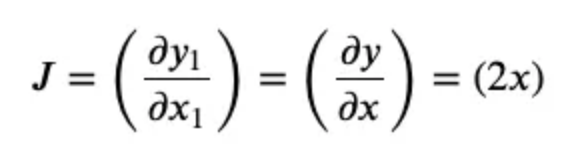

In [ ]:
#in numpy
x = x.detach().numpy() #input convert to numpy
J = array([[2*x]])
print('J:', J)

J: [[2.]]


In this example, we did not pass the gradient argument to backward(), and this defaults to passing the value 1. As a reminder, vᵀ is our gradientwith value 1. We can confirm that vᵀ・J gives the same result as x.grad.

In [ ]:
vᵀ = array([[1,]])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

vᵀ: [[1]]
vᵀ・J: [[2.]]


We can try to pass a non-default gradient with the value 100 to backward() instead of the default value 1.

In [ ]:
x = tensor(1., requires_grad=True)
print('x:', x)
y = x**2
print('y:', y)
gradient_value = 100.
y.backward(tensor(gradient_value))
print('x.grad:', x.grad)

x: tensor(1., requires_grad=True)
y: tensor(1., grad_fn=<PowBackward0>)
x.grad: tensor(200.)


In [ ]:
#numpy version - match with pytorch results
x = x.detach().numpy()
J = array([[2*x]])
print('J:', J)
vᵀ = array([[gradient_value,]])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

J: [[2.]]
vᵀ: [[100.]]
vᵀ・J: [[200.]]


Another Eample: input is vector, output is scalar

x=[x_1,x_2]=[1,2] is a vector and y=sum(x) is a scalar.

In [ ]:
x = tensor([1., 2.], requires_grad=True)
print('x:', x)
y = sum(x)
print('y:', y)
y.backward()
print('x.grad:', x.grad)

x: tensor([1., 2.], requires_grad=True)
y: tensor(3., grad_fn=<AddBackward0>)
x.grad: tensor([1., 1.])


Now manually calculate Jacobian J. In this since x is a vector with components x_1 and x_2, and y=x_1+x_2 is a scalar. We have

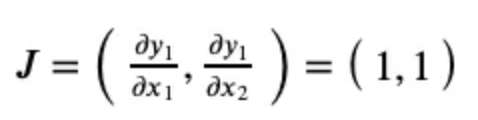

In [ ]:
#in numpy
J = array([[1, 1]])
print('J:')
print(J)

J:
[[1 1]]


In this example, we did not pass the gradient argument to backward(), and this defaults to passing the value 1, i.e., vᵀ has value 1. We can confirm that vᵀ・J gives the same result as x.grad.

In [ ]:
vᵀ = array([[1]])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

vᵀ: [[1]]
vᵀ・J: [[1 1]]


We can now pass a non-default gradient with the value 100 to backward() instead of the default value 1. Still, x=[x_1,x_2]=[1,2] is a vector and y=sum(x) is a scalar.

In [ ]:
x = tensor([1., 2.], requires_grad=True)
print('x:', x)
y = sum(x)
gradient_value = 100.
y.backward(tensor(gradient_value))
print('x.grad:', x.grad)

x: tensor([1., 2.], requires_grad=True)
x.grad: tensor([100., 100.])


This is the same as setting the value 100 for vᵀ, and we can see vᵀ・J still matches x.grad

In [ ]:
J = array([[1, 1]])
print('J:')
print(J)
vᵀ = array([[gradient_value,]])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

J:
[[1 1]]
vᵀ: [[100.]]
vᵀ・J: [[100. 100.]]


Another example: input is vector, output is vector

example where both x=[x_1,x_2]=[1,2] and y=3x^2 are vectors.

In [ ]:
x = tensor([1., 2.], requires_grad=True)
print('x:', x)
y = 3*x**2
print('y:', y)
gradient_value = [1., 1.]
y.backward(tensor(gradient_value))
print('x.grad:', x.grad)

x: tensor([1., 2.], requires_grad=True)
y: tensor([ 3., 12.], grad_fn=<MulBackward0>)
x.grad: tensor([ 6., 12.])


Now manually calculate Jacobian J. In this since x is a vector with components x_1 and x_2, and y=3x^2 is a vector with component y_1=3x_1^2and y_2=3x_2^2. We have

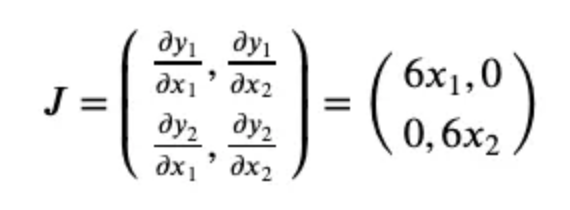

In [ ]:
#in numpy
x = x.detach().numpy()
J = array([[6*x[0], 0], [0, 6*x[1]]])
print('J:')
print(J)

J:
[[ 6.  0.]
 [ 0. 12.]]


In this example, because y is a vector, we must pass a gradient argument to backward(). We pass vᵀ with the same length as y and has values 1. We can confirm that vᵀ・J gives the same result as x.grad.

In [ ]:
vᵀ = array([gradient_value])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

vᵀ: [[1. 1.]]
vᵀ・J: [[ 6. 12.]]


We can keep everything else the same as above but pass a non-default gradient with the value [1, 10] to backward().

In [ ]:
x = tensor([1., 2.], requires_grad=True)
print('x:', x)
y = 3*x**2
print('y:', y)
gradient_value = [1., 10.]
y.backward(tensor(gradient_value))
print('x.grad:', x.grad)

x: tensor([1., 2.], requires_grad=True)
y: tensor([ 3., 12.], grad_fn=<MulBackward0>)
x.grad: tensor([  6., 120.])


This is the same as setting the value [1,10] for vᵀ, and we can see vᵀ・J still matches x.grad.

In [ ]:
x = x.detach().numpy()
J = array([[6*x[0], 0], [0, 6*x[1]]])
print('J:')
print(J)
vᵀ = array([gradient_value])
print('vᵀ:', vᵀ)
print('vᵀ・J:', vᵀ@J)

J:
[[ 6.  0.]
 [ 0. 12.]]
vᵀ: [[ 1. 10.]]
vᵀ・J: [[  6. 120.]]


Tutorial: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#gradients

Let's take a look at how ``autograd`` collects gradients. We create two tensors ``a`` and ``b`` with
``requires_grad=True``. This signals to ``autograd`` that every operation on them should be tracked.

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor ``Q`` from ``a`` and ``b``.

\begin{align}Q = 3a^3 - b^2\end{align}



In [ ]:
Q = 3*a**3 - b**2

Let's assume ``a`` and ``b`` to be parameters of an NN, and ``Q``
to be the error. In NN training, we want gradients of the error
w.r.t. parameters, i.e.

\begin{align}\frac{\partial Q}{\partial a} = 9a^2\end{align}

\begin{align}\frac{\partial Q}{\partial b} = -2b\end{align}


When we call ``.backward()`` on ``Q``, autograd calculates these gradients
and stores them in the respective tensors' ``.grad`` attribute.

We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself, i.e.

\begin{align}\frac{dQ}{dQ} = 1\end{align}

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like ``Q.sum().backward()``.




In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in ``a.grad`` and ``b.grad``

In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


Another Example:

In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


Notice that when we call ``backward`` for the second time with the same
argument, the value of the gradient is different. This happens because
when doing ``backward`` propagation, PyTorch **accumulates the
gradients**, i.e. the value of computed gradients is added to the
``grad`` property of all leaf nodes of computational graph. If you want
to compute the proper gradients, you need to zero out the ``grad``
property before. In real-life training an *optimizer* helps us to do
this.

### Fitting sine wave

Here we use PyTorch Tensors and autograd to implement our fitting sine wave with third order polynomial example; now we no longer need to manually implement the backward pass through the network:

In [ ]:
# -*- coding: utf-8 -*-
import torch
import math

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For a third order polynomial, we need
# 4 weights: y = a + b x + c x^2 + d x^3
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.randn((), device=device, dtype=dtype, requires_grad=True)
b = torch.randn((), device=device, dtype=dtype, requires_grad=True)
c = torch.randn((), device=device, dtype=dtype, requires_grad=True)
d = torch.randn((), device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(2000):
    # Forward pass: compute predicted y using operations on Tensors.
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 634.0364990234375
199 436.99639892578125
299 302.3916015625
399 210.33184814453125
499 147.29736328125
599 104.08721923828125
699 74.43286895751953
799 54.058372497558594
899 40.04411697387695
999 30.393878936767578
1099 23.741336822509766
1199 19.15045166015625
1299 15.978865623474121
1399 13.78552532196045
1499 12.267154693603516
1599 11.215006828308105
1699 10.485196113586426
1799 9.978507041931152
1899 9.62640380859375
1999 9.381498336791992
Result: y = -0.022344380617141724 + 0.8461494445800781 x + 0.003854779526591301 x^2 + -0.09182385355234146 x^3


Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level. When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.


### Pytorch NN package


PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.optim`](https://pytorch.org/docs/stable/optim.html), [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html).

| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above). |

Almost everything in a PyTorch neural network comes from `torch.nn`,
* `nn.Module` contains the larger building blocks (layers)
* `nn.Parameter` contains the smaller parameters like weights and biases (put these together to make `nn.Module`(s))
* `forward()` tells the larger blocks how to make calculations on inputs (tensors full of data) within  `nn.Module`(s)
* `torch.optim` contains optimization methods on how to improve the parameters within `nn.Parameter` to better represent input data

In PyTorch, the nn package serves this same purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In [ ]:
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# For this example, the output y is a linear function of (x, x^2, x^3), so
# we can consider it as a linear layer neural network. Let's prepare the
# tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# In the above code, x.unsqueeze(-1) has shape (2000, 1), and p has shape
# (3,), for this case, broadcasting semantics will apply to obtain a tensor
# of shape (2000, 3)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. The Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
# The Flatten layer flatens the output of the linear layer to a 1D tensor,
# to match the shape of `y`.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1), #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    torch.nn.Flatten(0, 1) #torch.nn.Flatten(start_dim=1, end_dim=-1)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-6
for t in range(2000):

    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 1196.42236328125
199 796.197998046875
299 530.9425048828125
399 355.11273193359375
499 238.54122924804688
599 161.24301147460938
699 109.97754669189453
799 75.97032928466797
899 53.406864166259766
999 38.432647705078125
1099 28.492874145507812
1199 21.89316177368164
1299 17.509977340698242
1399 14.598071098327637
1499 12.66296672821045
1599 11.376604080200195
1699 10.52121639251709
1799 9.952178955078125
1899 9.573487281799316
1999 9.32139778137207
Result: y = 0.008382523432374 + 0.8363150954246521 x + -0.0014461253304034472 x^2 + -0.09042500704526901 x^3


### Optim package

The optim package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.



In [ ]:
# -*- coding: utf-8 -*-
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
for t in range(2000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


linear_layer = model[0]
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

99 17306.95703125
199 6605.4892578125
299 1965.266357421875
399 376.6326599121094
499 67.86810302734375
599 42.26485824584961
699 36.94180679321289
799 30.957773208618164
899 23.898305892944336
999 17.004165649414062
1099 11.943888664245605
1199 9.503978729248047
1299 8.88857364654541
1399 8.834590911865234
1499 8.931175231933594
1599 8.831658363342285
1699 8.870916366577148
1799 8.878030776977539
1899 8.982465744018555
1999 8.965527534484863
Result: y = -0.0004978329525329173 + 0.8561474084854126 x + -0.0004978657816536725 x^2 + -0.09392453730106354 x^3


### Using nn.Module

define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In [ ]:
import torch
import math


class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined
# with torch.nn.Parameter) which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
for t in range(2000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Result: {model.string()}')

99 2149.70556640625
199 1470.2083740234375
299 1007.5223388671875
399 692.1107788085938
499 476.8498229980469
599 329.77142333984375
699 229.1632537841797
799 160.2637176513672
899 113.0250015258789
999 80.60042572021484
1099 58.3189697265625
1199 42.990352630615234
1299 32.43324661254883
1399 25.154510498046875
1499 20.130582809448242
1599 16.659332275390625
1699 14.258384704589844
1799 12.59603214263916
1899 11.443916320800781
1999 10.644678115844727
Result: y = -0.039336882531642914 + 0.8362022638320923 x + 0.006786266341805458 x^2 + -0.09040895849466324 x^3
